# Improved Model Training for AI Video Detection

This notebook includes:
- Better data augmentation
- Early stopping to prevent overfitting
- Class weights for imbalanced data
- Model checkpointing
- Better validation


In [6]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
import numpy as np
import matplotlib.pyplot as plt


In [7]:
# Configuration
data_directory = '/Users/dimashmadiyar/Documents/GitHub/HackPrinceton25/backend/data'
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
SEED = 42
VALIDATION_SPLIT = 0.2
EPOCHS = 50  # More epochs but with early stopping


In [8]:
# Enhanced data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation (no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    data_directory,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED
)

# Load validation data
validation_generator = val_datagen.flow_from_directory(
    data_directory,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=SEED
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")


Found 2795 images belonging to 3 classes.
Found 697 images belonging to 3 classes.
Training samples: 2795
Validation samples: 697
Class indices: {'fake': 0, 'real': 1, 'test_0': 2}


In [10]:
# Calculate class weights to handle imbalance
# Use the actual class distribution from the training generator
# fake=0, real=1 (alphabetically: fake comes before real)
import numpy as np

# Get class distribution from training generator
class_counts = train_generator.classes
unique, counts = np.unique(class_counts, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Get counts (handle case where a class might be missing)
fake_count = class_distribution.get(0, 0)  # fake class
real_count = class_distribution.get(1, 0)  # real class

total = fake_count + real_count

# Calculate class weights (avoid division by zero)
if fake_count > 0 and real_count > 0:
    class_weights = {
        0: total / (2 * fake_count),  # fake class weight
        1: total / (2 * real_count)   # real class weight
    }
else:
    # If one class is missing, use equal weights
    class_weights = {0: 1.0, 1: 1.0}
    print("Warning: One or more classes have no samples. Using equal weights.")

print(f"Fake samples: {fake_count}, Real samples: {real_count}")
print(f"Class weights: {class_weights}")


Fake samples: 1511, Real samples: 1280
Class weights: {0: np.float64(0.9235605559232296), 1: np.float64(1.090234375)}


In [11]:
# Improved model architecture with BatchNormalization
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Flatten
    Flatten(),
    
    # Fully Connected Layers
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    # Output layer
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,037,121 (72.62 MB)

 Trainable params: 19,035,649 (72.62 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [12]:
# Callbacks for better training
callbacks = [
    # Stop training if validation accuracy doesn't improve for 10 epochs
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    # Save the best model
    ModelCheckpoint(
        '/Users/dimashmadiyar/Documents/GitHub/HackPrinceton25/backend/models/ai_detector_model_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    # Reduce learning rate if validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]


In [13]:
# Calculate steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    class_weight=class_weights,  # Use class weights
    callbacks=callbacks,
    verbose=1
)


Steps per epoch: 87
Validation steps: 21
Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.7344 - loss: 0.7294
Epoch 1: val_accuracy improved from None to 0.54167, saving model to /Users/dimashmadiyar/Documents/GitHub/HackPrinceton25/backend/models/ai_detector_model_best.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 49s 538ms/step - accuracy: 0.7941 - loss: 0.5269 - val_accuracy: 0.5417 - val_loss: 6.3054 - learning_rate: 0.0010
Epoch 2/50
 1/87 ━━━━━━━━━━━━━━━━━━━━ 46s 545ms/step - accuracy: 0.6875 - loss: 0.7314

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.54167
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.6875 - loss: 0.7314 - val_accuracy: 0.5402 - val_loss: 6.2515 - learning_rate: 0.0010
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.8419 - loss: 0.3793
Epoch 3: val_accuracy did not improve from 0.54167
87/87 ━━━━━━━━━━━━━━━━━━━━ 56s 647ms/step - accuracy: 0.8411 - loss: 0.3766 - val_accuracy: 0.5372 - val_loss: 8.6120 - learning_rate: 0.0010
Epoch 4/50
 1/87 ━━━━━━━━━━━━━━━━━━━━ 52s 613ms/step - accuracy: 0.7500 - loss: 0.5548
Epoch 4: val_accuracy improved from 0.54167 to 0.54464, saving model to /Users/dimashmadiyar/Documents/GitHub/HackPrinceton25/backend/models/ai_detector_model_best.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7500 - loss: 0.5548 - val_accuracy: 0.5446 - val_loss: 8.3680 - learning_rate: 0.0010
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.8732 - loss: 0.3079
Epoch 5: val_accuracy did not improve from 0.5

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.7116 - loss: 1.1379

Final Validation Loss: 1.1379
Final Validation Accuracy: 71.16%


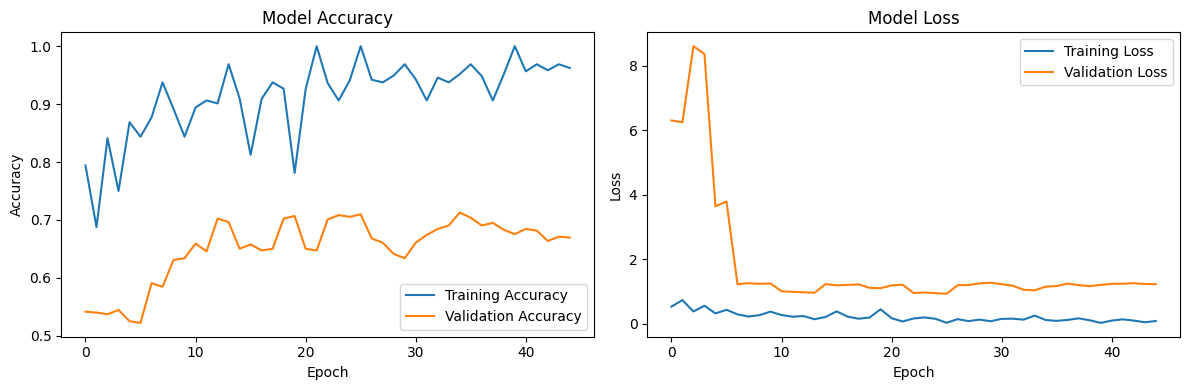

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator, verbose=1)
print(f"\nFinal Validation Loss: {loss:.4f}")
print(f"Final Validation Accuracy: {accuracy*100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# Save the final model (use the best checkpoint)
import shutil
shutil.copy(
    '/Users/dimashmadiyar/Documents/GitHub/HackPrinceton25/backend/models/ai_detector_model_best.keras',
    '/Users/dimashmadiyar/Documents/GitHub/HackPrinceton25/backend/models/ai_detector_model.keras'
)
print("Model saved successfully!")


Model saved successfully!
